In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Load your cleaned data
df = pd.read_csv('data_cleaned.csv')
print(f"Loaded {len(df)} cleaned reviews")
print(f"Columns: {df.columns.tolist()}")

Loaded 314440 cleaned reviews
Columns: ['Unnamed: 0', 'review_id', 'pseudo_author_id', 'author_name', 'review_text', 'review_rating', 'review_likes', 'author_app_version', 'review_timestamp', 'review_length', 'review_year', 'review_month', 'review_day']


In [2]:
def create_labeling_rules():
    """Define keyword-based labeling rules for each class"""
    
    rules = {
        'Positive': {
            'keywords': ['love', 'great', 'awesome', 'excellent', 'amazing', 'perfect', 'best', 'helpful', 'useful', 'good', 'nice', 'wonderful', 'fantastic', 'outstanding'],
            'rating_threshold': 4,
            'negative_keywords': ['hate', 'terrible', 'awful', 'worst', 'useless', 'annoying']
        },
        'Negative': {
            'keywords': ['hate', 'terrible', 'awful', 'worst', 'useless', 'annoying', 'frustrating', 'disappointing', 'bad', 'poor', 'horrible', 'ridiculous'],
            'rating_threshold': 2,
            'negative_keywords': ['love', 'great', 'awesome', 'excellent']
        },
        'Bug Report': {
            'keywords': ['crash', 'error', 'bug', 'not working', 'fails', 'freeze', 'broken', 'issue', 'problem', 'doesn\'t work', 'won\'t load', 'crashes', 'errors', 'bugs'],
            'rating_threshold': None,
            'negative_keywords': []
        },
        'Feature Request': {
            'keywords': ['wish', 'add', 'should have', 'need option', 'missing', 'would like', 'could use', 'suggestion', 'feature', 'option', 'include', 'implement'],
            'rating_threshold': None,
            'negative_keywords': []
        },
        'Spam': {
            'keywords': ['check out', 'visit', 'http', 'www', 'click', 'download', 'free', 'earn money', 'make money'],
            'rating_threshold': None,
            'negative_keywords': []
        }
    }
    
    return rules

def apply_labeling_rules(text, rating, rules):
    """Apply labeling rules to a single review"""
    
    if pd.isna(text) or text == '':
        return 'Unknown'
    
    text_lower = text.lower()
    
    # Check for spam first (highest priority)
    if any(keyword in text_lower for keyword in rules['Spam']['keywords']):
        return 'Spam'
    
    # Check for very short/generic reviews that might be spam
    if len(text.strip()) < 10 and rating <= 2:
        return 'Spam'
    
    # Check for bug reports
    if any(keyword in text_lower for keyword in rules['Bug Report']['keywords']):
        return 'Bug Report'
    
    # Check for feature requests
    if any(keyword in text_lower for keyword in rules['Feature Request']['keywords']):
        return 'Feature Request'
    
    # Check for positive/negative based on keywords and rating
    positive_score = sum(1 for keyword in rules['Positive']['keywords'] if keyword in text_lower)
    negative_score = sum(1 for keyword in rules['Negative']['keywords'] if keyword in text_lower)
    
    # Penalize if negative keywords are present
    positive_score -= sum(1 for keyword in rules['Positive']['negative_keywords'] if keyword in text_lower)
    negative_score -= sum(1 for keyword in rules['Negative']['negative_keywords'] if keyword in text_lower)
    
    # Consider rating
    if rating >= rules['Positive']['rating_threshold']:
        positive_score += 2
    elif rating <= rules['Negative']['rating_threshold']:
        negative_score += 2
    
    # Determine label
    if positive_score > negative_score and positive_score > 0:
        return 'Positive'
    elif negative_score > positive_score and negative_score > 0:
        return 'Negative'
    else:
        # Default based on rating
        if rating >= 4:
            return 'Positive'
        elif rating <= 2:
            return 'Negative'
        else:
            return 'Neutral'

# Apply labeling
rules = create_labeling_rules()
df['predicted_label'] = df.apply(lambda row: apply_labeling_rules(row['review_text'], row['review_rating'], rules), axis=1)

print("Labeling completed!")
print("\nLabel distribution:")
print(df['predicted_label'].value_counts())

Labeling completed!

Label distribution:
predicted_label
Positive           226375
Negative            39589
Bug Report          15429
Spam                12197
Neutral             10755
Feature Request     10095
Name: count, dtype: int64


In [6]:
def create_labeling_rules():
    """Define keyword-based labeling rules for each class"""
    
    rules = {
        'Positive': {
            'keywords': ['love', 'great', 'awesome', 'excellent', 'amazing', 'perfect', 'best', 'helpful', 'useful', 'good', 'nice', 'wonderful', 'fantastic', 'outstanding'],
            'rating_threshold': 4,
            'negative_keywords': ['hate', 'terrible', 'awful', 'worst', 'useless', 'annoying']
        },
        'Negative': {
            'keywords': ['hate', 'terrible', 'awful', 'worst', 'useless', 'annoying', 'frustrating', 'disappointing', 'bad', 'poor', 'horrible', 'ridiculous'],
            'rating_threshold': 2,
            'negative_keywords': ['love', 'great', 'awesome', 'excellent']
        },
        'Bug Report': {
            'keywords': ['crash', 'error', 'bug', 'not working', 'fails', 'freeze', 'freezes', 'freezing', 'broken', 'issue', 'problem', 'doesn\'t work', 'won\'t load', 'crashes', 'errors', 'bugs', 'stuck', 'hangs', 'unresponsive'],
            'rating_threshold': None,
            'negative_keywords': []
        },
        'Feature Request': {
            'keywords': ['wish', 'add', 'should have', 'need option', 'missing', 'would like', 'could use', 'suggestion', 'feature', 'option', 'include', 'implement'],
            'rating_threshold': None,
            'negative_keywords': []
        },
        'Spam': {
            'keywords': ['check out', 'visit', 'http', 'www', 'click', 'download', 'free', 'earn money', 'make money', 'get rich', 'work from home', 'buy now', 'limited time'],
            'rating_threshold': None,
            'negative_keywords': []
        }
    }
    
    return rules

def apply_labeling_rules(text, rating, rules):
    """Apply labeling rules to a single review"""
    
    if pd.isna(text) or text == '':
        return 'Unknown'
    
    text_lower = text.lower()
    
    # Check for spam first (highest priority)
    if any(keyword in text_lower for keyword in rules['Spam']['keywords']):
        return 'Spam'
    
    # Check for very short/generic reviews that might be spam
    if len(text.strip()) < 10 and rating <= 2:
        return 'Spam'
    
    # Check for bug reports
    if any(keyword in text_lower for keyword in rules['Bug Report']['keywords']):
        return 'Bug Report'
    
    # Check for feature requests
    if any(keyword in text_lower for keyword in rules['Feature Request']['keywords']):
        return 'Feature Request'
    
    # Check for positive/negative based on keywords and rating
    positive_score = sum(1 for keyword in rules['Positive']['keywords'] if keyword in text_lower)
    negative_score = sum(1 for keyword in rules['Negative']['keywords'] if keyword in text_lower)
    
    # Penalize if negative keywords are present
    positive_score -= sum(1 for keyword in rules['Positive']['negative_keywords'] if keyword in text_lower)
    negative_score -= sum(1 for keyword in rules['Negative']['negative_keywords'] if keyword in text_lower)
    
    # Consider rating
    if rating >= rules['Positive']['rating_threshold']:
        positive_score += 2
    elif rating <= rules['Negative']['rating_threshold']:
        negative_score += 2
    
    # Determine label (removed Neutral class)
    if positive_score > negative_score and positive_score > 0:
        return 'Positive'
    elif negative_score > positive_score and negative_score > 0:
        return 'Negative'
    else:
        # Default based on rating (no more Neutral)
        if rating >= 4:
            return 'Positive'
        elif rating <= 2:
            return 'Negative'
        else:
            # For rating 3, check if there are any positive/negative indicators
            if positive_score > 0:
                return 'Positive'
            elif negative_score > 0:
                return 'Negative'
            else:
                return 'Positive'  # Default to positive for rating 3

# Apply the updated labeling
rules = create_labeling_rules()
df['predicted_label'] = df.apply(lambda row: apply_labeling_rules(row['review_text'], row['review_rating'], rules), axis=1)

# Remove any remaining 'Neutral' labels
df = df[df['predicted_label'] != 'Neutral']

print("Updated labeling completed!")
print("\nNew label distribution:")
print(df['predicted_label'].value_counts())

Updated labeling completed!

New label distribution:
predicted_label
Positive           236957
Negative            39161
Bug Report          16033
Spam                12240
Feature Request     10049
Name: count, dtype: int64


=== LABELING ANALYSIS ===
Total reviews labeled: 314440

Label distribution:
predicted_label
Positive           236957
Negative            39161
Bug Report          16033
Spam                12240
Feature Request     10049
Name: count, dtype: int64


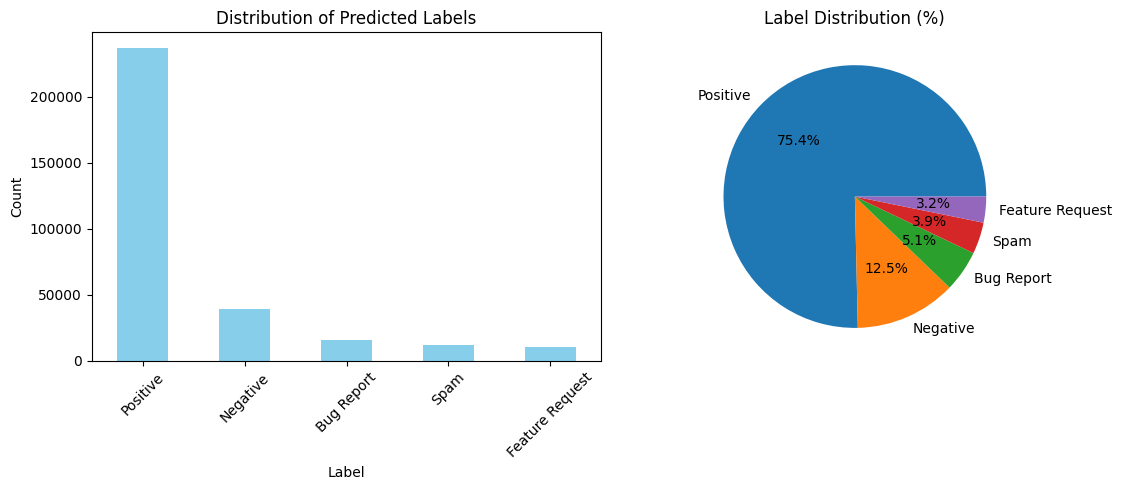


=== LABEL DISTRIBUTION BY RATING ===
predicted_label  Bug Report  Feature Request  Negative  Positive  Spam
review_rating                                                         
1                      7590             2525     29896        51  7302
2                      2601             1183      8590        26  2224
3                      2337             1784       666     16114   818
4                      1771             2120         7     43606   655
5                      1734             2437         2    177160  1241

=== SAMPLE REVIEWS BY LABEL ===

Positive reviews:
  Rating 5: Well designed app. It's much easier to use than the web site on my phone....
  Rating 5: Cool!...
  Rating 5: Great to finally see this on the market!...

Feature Request reviews:
  Rating 4: Missing contact synching found in other apps like facebook and twitter...
  Rating 1: Useless without syncing contacts to the address book....
  Rating 2: Extremely limited features. This is the same as the be

In [7]:
# Analyze the labeling results
print("=== LABELING ANALYSIS ===")
print(f"Total reviews labeled: {len(df)}")
print("\nLabel distribution:")
label_counts = df['predicted_label'].value_counts()
print(label_counts)

# Visualize label distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
label_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Predicted Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
label_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Label Distribution (%)')
plt.ylabel('')

plt.tight_layout()
plt.show()

# Analyze by rating
print("\n=== LABEL DISTRIBUTION BY RATING ===")
rating_label_cross = pd.crosstab(df['review_rating'], df['predicted_label'])
print(rating_label_cross)

# Show some examples of each label
print("\n=== SAMPLE REVIEWS BY LABEL ===")
for label in df['predicted_label'].unique():
    if label != 'Unknown':
        print(f"\n{label} reviews:")
        sample_reviews = df[df['predicted_label'] == label][['review_text', 'review_rating']].head(3)
        for _, row in sample_reviews.iterrows():
            print(f"  Rating {row['review_rating']}: {row['review_text'][:100]}...")

In [8]:
# Save the labeled dataset
output_file = 'data/labeled_reviews.csv'
df.to_csv(output_file, index=False)
print(f"Labeled dataset saved to {output_file}")

# Also save a sample for manual review
sample_size = min(100, len(df))
sample_df = df.sample(n=sample_size, random_state=42)
sample_df.to_csv('data/labeled_sample_for_review.csv', index=False)
print(f"Sample of {sample_size} reviews saved for manual review")

print("\nNext steps:")
print("1. Review the sample file manually to validate labeling quality")
print("2. Adjust labeling rules if needed")
print("3. Proceed to model training")

Labeled dataset saved to data/labeled_reviews.csv
Sample of 100 reviews saved for manual review

Next steps:
1. Review the sample file manually to validate labeling quality
2. Adjust labeling rules if needed
3. Proceed to model training
